# Predicting whether or not a player is in the NBA next season

In this notebook we perform model selection with the goal of generating the best classifier for the response variable `IN_LEAGUE_NEXT`, whether or not a given player will play at any point in the next NBA season (and thus have stats data).

We will do all model selection using _only_ the set of training data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Loading the data

In [2]:
# load the data and drop TEAMS_LIST and POS rows
df_train = pd.read_csv("./train_data.csv").drop(columns=['TEAMS_LIST', 'POS'])

## Imputing and scaling

Note that all of the transformations we will perform here will be performed "within season," meaning that the data for a given season is transformed using information from *only* that season and no other. In particular, since at the time of prediction we will have access to all of the data for that particular season, there is no data leakage occuring.

### Imputing missing values

In [3]:
# check how many missing values in each column
len(df_train) - df_train.count()[df_train.count() < len(df_train)]

PER              3
TS_PERCENT      35
X3P_AR          40
F_TR            40
ORB_PERCENT      3
DRB_PERCENT      3
TRB_PERCENT      3
AST_PERCENT      3
STL_PERCENT      3
BLK_PERCENT      3
TOV_PERCENT     27
USG_PERCENT      3
WS_48            3
SALARY         568
dtype: int64

One option is to simply drop all rows which contain a missing value.

In [4]:
# drop rows with null values
# df_train = df_train.dropnna()

Another option is to impute the missing values. We will try imputing all missing stats with 0, except for `SALARY`.

In [5]:
# fill null values with 0 for all columns except SALARY
null_cols = ['PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
             'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'WS_48']

df_train[null_cols] = df_train[null_cols].fillna(0)

For `SALARY`, we will use a mean imputer within each season.

In [6]:
from sklearn.impute import SimpleImputer

mean_imputer = SimpleImputer(strategy='mean')

# replace salaries of 0 with null
df_train.loc[df_train['SALARY']==0, 'SALARY'] = None

# apply mean imputer for SALARY within each season
df_train['SALARY'] = (
    df_train
    .groupby('SEASON_START')['SALARY']
    .transform(lambda x: mean_imputer.fit_transform(x.values.reshape(-1,1)).ravel())
)

### Scaling

Now we will use a standard scaler within each season.

In [7]:
# rescale stats and salary columns within each season
cols_to_rescale = df_train.select_dtypes(include=['float']).columns
print(cols_to_rescale)

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY'],
      dtype='object')


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# apply standard scaler within each season
df_train[cols_to_rescale] = (
    df_train
    .groupby('SEASON_START')[cols_to_rescale]
    .transform(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).ravel())
)

In [9]:
# check that it worked: randomly select a rescaled column, and check that the mean for each season
# is 0 and the standard deviation is 1

# display numbers smaller than 1e-15 as 0
pd.set_option('display.chop_threshold', 1e-15)

random_rescaled_col = np.random.choice(cols_to_rescale)

print(f"Randomly selected rescaled column: {random_rescaled_col}")
df_train.groupby("SEASON_START")[random_rescaled_col].describe()[["mean", "std"]]

Randomly selected rescaled column: TRB_PERCENT


,mean,std
SEASON_START,,
1990,0.000000e+00,1.001294
1991,0.000000e+00,1.001298
1992,0.000000e+00,1.001285
1993,0.000000e+00,1.001243
1994,0.000000e+00,1.001231
1995,0.000000e+00,1.001168
1996,0.000000e+00,1.001136
1997,0.000000e+00,1.001141
1998,0.000000e+00,1.001138


## Correlations

Now we'll look at correlations between the predictors and the response variable.  Below we grab the numeric columns and make a correlation heatmap before printing the correlations with `IN_LEAGUE_NEXT`.

In [10]:
df_train.columns

Index(['NAME', 'PLAYER_ID', 'SEASON_START', 'PLAYER_AGE', 'EXPERIENCE', 'GP',
       'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'PER', 'TS_PERCENT', 'X3P_AR', 'F_TR', 'ORB_PERCENT',
       'DRB_PERCENT', 'TRB_PERCENT', 'AST_PERCENT', 'STL_PERCENT',
       'BLK_PERCENT', 'TOV_PERCENT', 'USG_PERCENT', 'OWS', 'DWS', 'WS',
       'WS_48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'SALARY', 'WAIVED', 'RELEASED',
       'TRADED', 'WAIVED_OFF', 'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF',
       'RELEASED_REG', 'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG',
       'TRADED_POST', 'IN_LEAGUE_NEXT'],
      dtype='object')

In [21]:
# grab all columns
all_cols = list(df_train.columns)

# grab just the columns with numeric data
num_cols = df_train.select_dtypes(include='number').columns.drop('PLAYER_ID')

# grab just the predictors for later; NOTE: leaving out SEASON_START as a predictor
predictors = num_cols.drop(['SEASON_START', 'IN_LEAGUE_NEXT'])

In [22]:
predictors

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')

IN_LEAGUE_NEXT    1.000000
GP                0.505385
PF                0.460802
MIN               0.454275
FGA               0.396110
FGM               0.395826
PTS               0.391002
TOV               0.390322
WAIVED            0.378325
DREB              0.377827
STL               0.374977
REB               0.373683
DWS               0.364216
WAIVED_REG        0.355055
WS                0.351836
Name: IN_LEAGUE_NEXT, dtype: float64


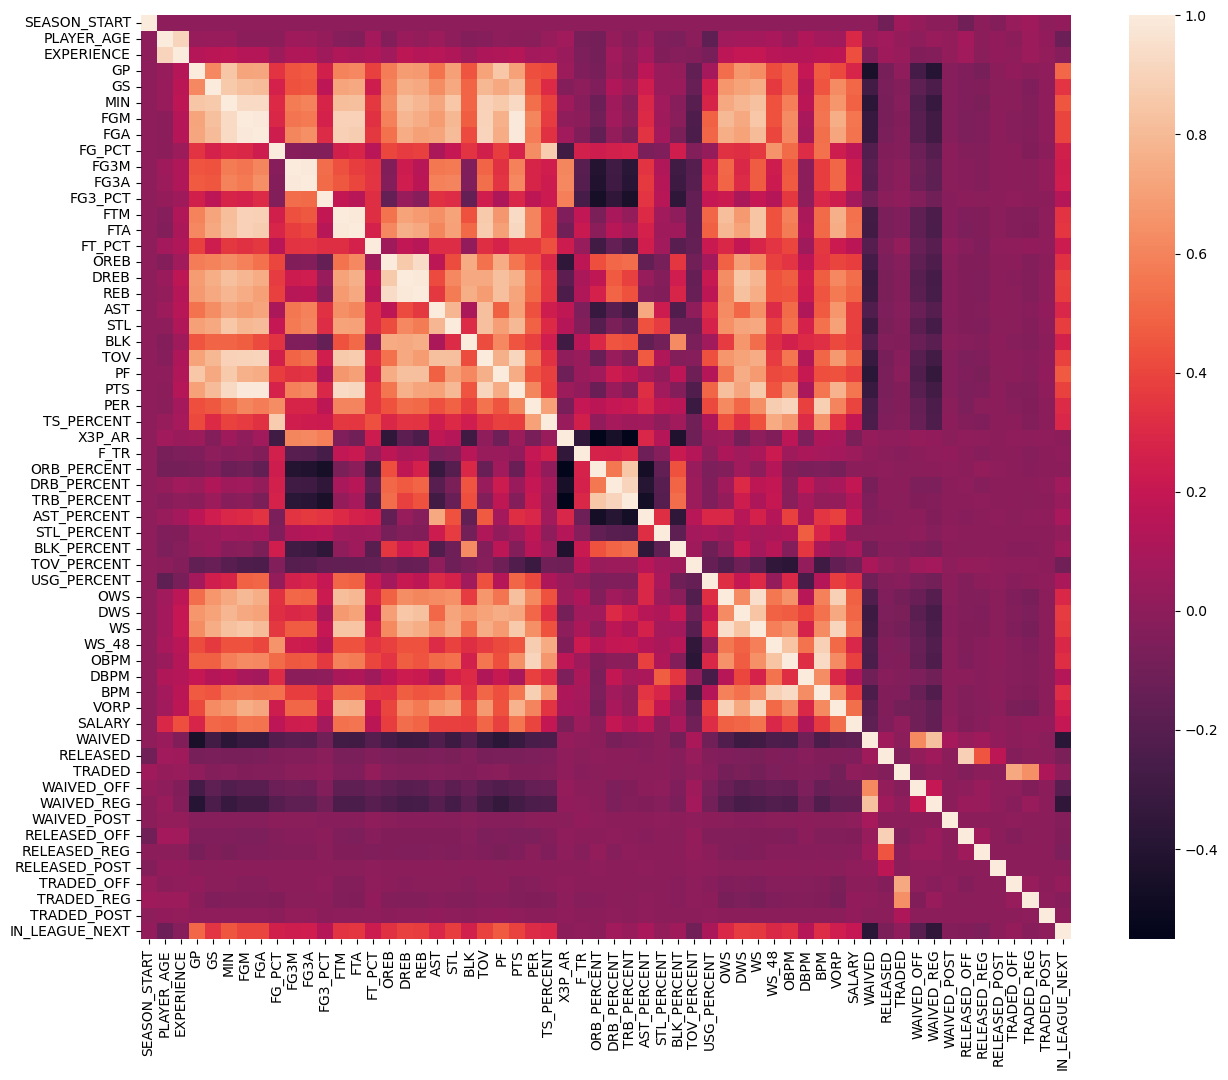

In [23]:
# compute correlations between numeric data columns
corr = df_train[num_cols].corr()

# print top 15 or so |correlations| with IN_LEAGUE_NEXT in descending order
print(abs(corr["IN_LEAGUE_NEXT"]).sort_values(ascending=False)[0:15])

# plot heatmap
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

# Model selection

## Cross validation structure

Since we aim to use known current-season player/stats data to predict whether a player is in the NBA in the future (next season), we have to worry about not introducing "future" data in the training/validation process.  For this reason we will use a time series approach to cross-validation known as "walk-forward validation" (with an expanding window).

Specifically, we will do a 5-fold time series cross-validation to estimate the performance of each model we consider.  The folds will have the following structure:

| CV Fold | CV train set seasons | CV validation set seasons |
| ---     | ---                  | ---                       |
| 1       | 1990 - 2011          | 2012                      |
| 2       | 1990 - 2012          | 2013                      |
| 3       | 1990 - 2013          | 2014                      |
| 4       | 1990 - 2014          | 2015                      |
| 5       | 1990 - 2015          | 2016                      |

where the minimum size of a CV training set is that of the first fold, which uses 79% of `df_train`; this is computed (along with the number of rows in the training/validation sets for each fold) in the cell below.

In [24]:
CUTOFF_YEAR = 2011

print(f"First fold trains on {len(df_train[df_train.SEASON_START <= CUTOFF_YEAR])/len(df_train)*100:.0f}% of df_train.")
print()

for fold in range(1, 6):
    val_season = fold + 2011
    fold_train = len(df_train[df_train.SEASON_START<val_season])
    fold_val = len(df_train[df_train.SEASON_START==val_season])
    print(f"Fold {fold} has train size {fold_train} and val. size {fold_val}")

First fold trains on 80% of df_train.

Fold 1 has train size 9560 and val. size 469
Fold 2 has train size 10029 and val. size 482
Fold 3 has train size 10511 and val. size 492
Fold 4 has train size 11003 and val. size 476
Fold 5 has train size 11479 and val. size 486


### Performance metrics

Below we define a helper function called `compute_metrics` which will compute all of the measures of classifier performance we will use during the model selection process.

In [25]:
# import the functions we need for modeling
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [26]:
def compute_metrics(true_y_vals, predictions):
    """
    Compute metrics given true y values and classifier predictions.
    Returns a list with the following components: balanced accuracy
    score, precision, recall, negative predictive value, and specificity.
    """

    # get the confusion matrix
    conf = confusion_matrix(true_y_vals, predictions)

    # grab true negatives, true positives, false positives, false negatives
    tn = conf[0,0]
    tp = conf[1,1]
    fp = conf[0,1]
    fn = conf[1,0]

    # balanced accuracy score
    bal_accuracy = balanced_accuracy_score(true_y_vals, predictions)
    # precision (positive predictive value): what % of players classified as 1's are true 1's?
    precision = tp/(tp+fp)
    # recall (sensitivity): what % of true 1's are classified as 1?
    recall = tp/(tp+fn)
    # negative predictive value (NPV): what % of players classified as 0's are true 0's?
    npv = tn/(tn+fn)
    # specificity: what % of true 0's are classified as 0?
    specificity = tn/(tn+fp)

    return np.array([bal_accuracy, precision, recall, npv, specificity])

### Cross-validation function

Below we write the timeseries-type cross-validation function.

In [27]:
def cross_validation(model, resample_SMOTE=True):
    """
    Does 5-fold walk-forward validation given a model. Prints classification metrics
    and displays the confusion matrix summed over all folds.
    """
    metrics = []
    conf_matrices = []

    for fold in range(1,6):
        val_season = fold + 2011

        X_tt = df_train[df_train.SEASON_START<val_season][predictors]
        y_tt = df_train[df_train.SEASON_START<val_season].IN_LEAGUE_NEXT
        X_val = df_train[df_train.SEASON_START==val_season][predictors]
        y_val = df_train[df_train.SEASON_START==val_season].IN_LEAGUE_NEXT

        if resample_SMOTE:
            # resample the training data using SMOTE
            smote = SMOTE(random_state=5)
            X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)
        else:
            # do not resample
            X_tt_re, y_tt_re = X_tt, y_tt

        # train the model
        model.fit(X_tt_re, y_tt_re)

        # get prediction and balanced accuracy scores for validation set
        pred = model.predict(X_val)

        # compute metrics and append them to list
        metrics.append(compute_metrics(y_val, pred))

        # compute confusion matrix and append it to a list
        conf_matrices.append(confusion_matrix(y_val, pred))

        print(f"CV fold {fold} complete")

    # print CV averaged metrics
    avg_bal_acc, avg_prec, avg_recall, avg_npv, avg_spec = np.mean(np.array(metrics), axis=0)
    full_conf_matrix = np.sum(conf_matrices, axis=0)

    print("\n" + "Classification metrics")
    print(f"Avg bal. accuracy: {avg_bal_acc:.3f}")
    print(f"Avg precision: {avg_prec:.3f}")
    print(f"Avg recall: {avg_recall:.3f}")
    print(f"Avg NPV: {avg_npv:.3f}")
    print(f"Avg specificity: {avg_spec:.3f}")

    ConfusionMatrixDisplay(full_conf_matrix).plot()

    return None

## Model 1: Naive logistic regression model

Let's begin by finding the 5-fold CV performance of a simple logistic regression model on the training set.  We train this model without accounting for the fact that our classes (values of `IN_LEAGUE_NEXT`) are imbalanced.

In [28]:
# show that we have imbalanced classes
df_train.IN_LEAGUE_NEXT.value_counts(normalize=False)

IN_LEAGUE_NEXT
1    9685
0    2280
Name: count, dtype: int64

In [29]:
from sklearn.linear_model import LogisticRegression

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.729
Avg precision: 0.894
Avg recall: 0.940
Avg NPV: 0.667
Avg specificity: 0.519


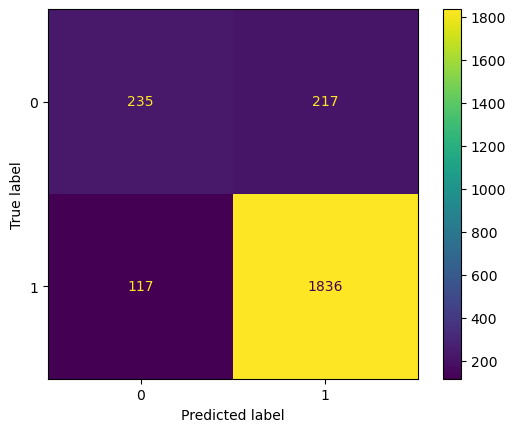

In [30]:
# define the model
lr = LogisticRegression(penalty=None, max_iter=10000)

# run the cross_validation function on the model
cross_validation(lr, resample_SMOTE=False)

## Model 2: Logistic regression model trained on balanced classes

We'll now address the fact that our classes are imbalanced by augmenting the training data used in each CV fold.  To do so, we'll use the `imblearn` library's data augmentation functions.  Of these functions, I find that the Synthetic Minority Oversampling Technique (SMOTE) gives the best performance.

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.794
Avg precision: 0.945
Avg recall: 0.784
Avg NPV: 0.463
Avg specificity: 0.803


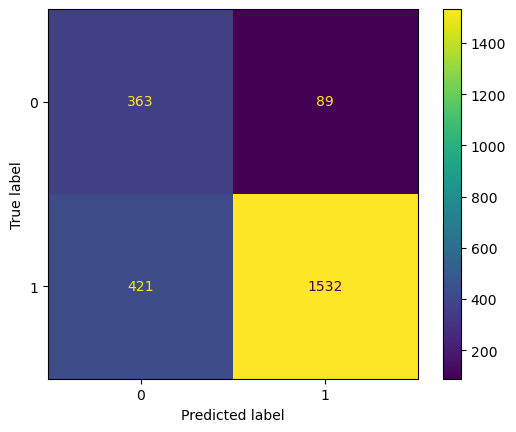

In [49]:
lr = LogisticRegression(penalty=None, max_iter=10000)
# lr = LogisticRegression(penalty='l2', C=0.001, max_iter=10000)

cross_validation(lr, resample_SMOTE=True)

### SMOTE-balanced training data gives improved performance.

Notice that the performance is about 10% better in terms of the balanced accuracy score, simply by training the model with a set of augmented data (from SMOTE).  That said, we have noticeably more false negatives after augmenting the data.

TODO: Do some hyperparameter (grid search or random search?) tuning with L2 regularization (this seems to definitely improve model performance).

## Models 3a-b: Linear Discriminant Analysis, Naive Bayes Classifier

Here we will try a couple more classifiers in much the same way as above.  Specifically, we use Linear Discriminant Analysis (LDA) and the Naive Bayes Classifier.

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.796
Avg precision: 0.949
Avg recall: 0.774
Avg NPV: 0.455
Avg specificity: 0.818


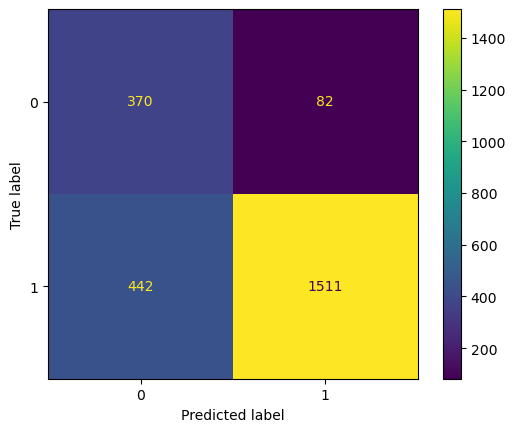

In [39]:
lda = LinearDiscriminantAnalysis()

cross_validation(lda)

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.782
Avg precision: 0.960
Avg recall: 0.689
Avg NPV: 0.395
Avg specificity: 0.876


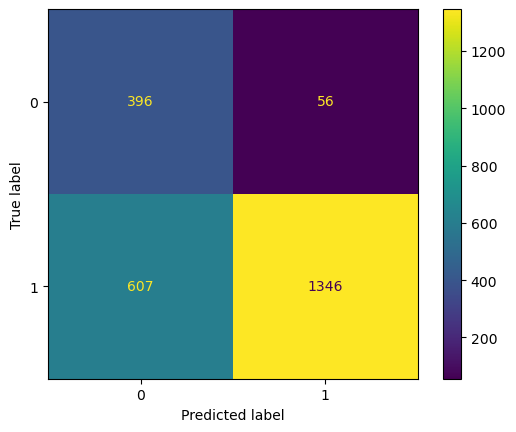

In [40]:
nb = GaussianNB()

cross_validation(nb)

### LDA, Naive Bayes are slightly worse than logistic regression.

The three models all have roughly the same performance, but LDA and NB have more false negatives than logistic regression.

## Models 4a-b: PCA + KNN, PCA + QDA

We will now consider a KNN model and a Quadratic Discriminant Analysis (QDA) model.  KNN is prone to the curse of dimensionality, so we will likely need to reduce the number of predictors before using it; we can do so using PCA.  QDA doesn't converge well if our predictors are collinear, as is the case here.  We'll use PCA to generate an orthogonal basis of predictors before using QDA.

In [41]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

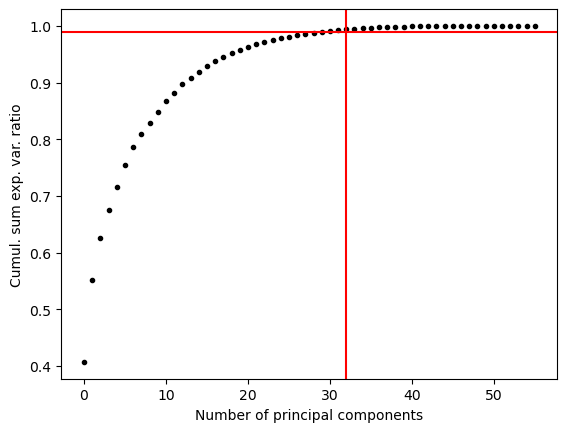

In [42]:
# scale the variables before applying PCA
pca = PCA(n_components=len(predictors))
pca.fit(df_train[predictors])

# grab the explained variance ratio
pca_EVR = pca.explained_variance_ratio_ #get the explained variance ratio

# get the cumulative sum of the explained variance ratio and plot it
pca_EVR_cumul = np.cumsum(pca_EVR)

plt.plot(pca_EVR_cumul, 'k.')
plt.xlabel("Number of principal components")
plt.ylabel("Cumul. sum exp. var. ratio")
plt.axhline(0.99, c='r')
plt.axvline(32, c='r')
plt.show()

### 32 principal components explain 99% of the variance in the predictors.

From the plot we can see that it takes 32 principal components to explain 99% of the variance in the predictors.  Hence we'll use 32 principal components in our KNN and QDA models.

KNN still has a hyperparameter (`n_neighbors`), so we will use a modified version of the `cross_validation` function to find it.

In [45]:
NUM_FOLDS = 5
MAX_KNN_K = 105

# store balanced accuracy score vs k (num_neighbors)
bal_acc_vs_k = np.zeros((NUM_FOLDS, MAX_KNN_K))

for fold in range(1,6):
    val_season = fold + 2011
    X_tt = df_train[df_train.SEASON_START<val_season][predictors]
    y_tt = df_train[df_train.SEASON_START<val_season].IN_LEAGUE_NEXT
    X_val = df_train[df_train.SEASON_START==val_season][predictors]
    y_val = df_train[df_train.SEASON_START==val_season].IN_LEAGUE_NEXT

    # resample the training data using SMOTE
    smote = SMOTE(random_state=5)
    X_tt_re, y_tt_re = smote.fit_resample(X_tt, y_tt)

    for k in range(1, MAX_KNN_K+1):
        # train the model
        knn = Pipeline([("pca", PCA(32)), ("knn", KNeighborsClassifier(k))])
        knn.fit(X_tt_re, y_tt_re)

        # get prediction and balanced accuracy scores for validation set
        pred = knn.predict(X_val)

        # compute balanced_accuracy_score for each fold (i) and value of n_neighbors (k)
        bal_acc_vs_k[fold-1, k-1] = balanced_accuracy_score(y_val, pred) # fold, k both start at 1

    print(f"CV fold {fold} complete")

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete


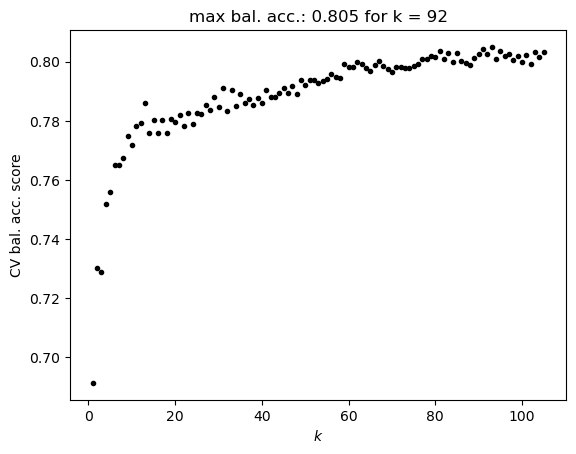

In [46]:
knn_k = range(1, MAX_KNN_K+1)
mean_acc_vs_k = np.mean(bal_acc_vs_k, axis=0)
best_k = np.argmax(mean_acc_vs_k)

plt.plot(knn_k, mean_acc_vs_k, 'k.')
plt.xlabel('$k$')
plt.ylabel('CV bal. acc. score')
plt.title(f"max bal. acc.: {np.amax(mean_acc_vs_k):.3f} for k = {best_k}")
plt.show()

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.802
Avg precision: 0.965
Avg recall: 0.715
Avg NPV: 0.419
Avg specificity: 0.890


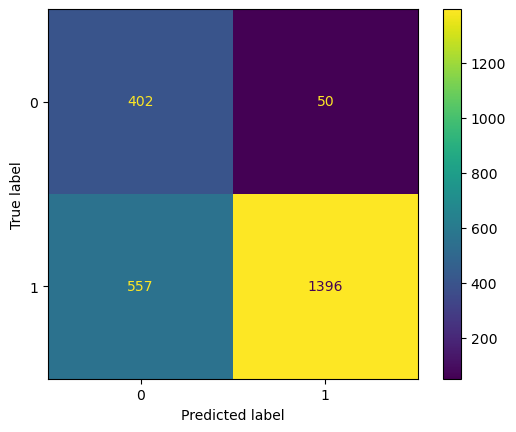

In [47]:
knn = Pipeline([("pca", PCA(32)), ("knn", KNeighborsClassifier(best_k))])

cross_validation(knn)

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.793
Avg precision: 0.941
Avg recall: 0.803
Avg NPV: 0.480
Avg specificity: 0.784


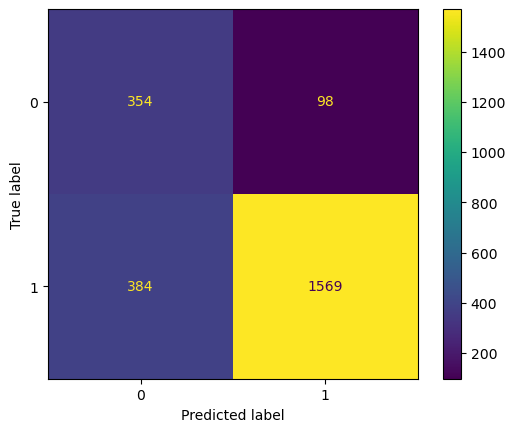

In [48]:
# now do QDA
qda = Pipeline([("pca", PCA(32)), ("qda", QuadraticDiscriminantAnalysis())])

cross_validation(qda, False) # QDA performs better with SMOTE off!

### KNN is worse than logistic regression. QDA (SMOTE off!) is slightly better.

Even with a tuned value of `num_neighbors`, KNN (with 32 principal components, which should explain > 99% of the variance of all predictors) performs noticeably worse than logistic regression and LDA.  It has few FPs, but many more FNs.  QDA has similar behavior with SMOTE on; for some reason, with SMOTE off, QDA has performance comparable to logistic regression.

## Model 5: Decision Tree Classifier

Now we try the decision tree classifier.  In this case we have a hyperparameter that needs tuning: the `max_depth`.  We find the best value for `max_depth` using `GridSearchCV`, and then run the same manual CV with the chosen value of `max_depth` to find the performance of the model and compute metrics.

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [51]:
# get the resampled data
smote = SMOTE(random_state=5)
X_train = df_train[predictors]
y_train = df_train.IN_LEAGUE_NEXT
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)

# make the GridSearchCV object, fit it, save the best value for max_depth
dt = DecisionTreeClassifier(random_state=25)
tree_gscv = GridSearchCV(dt, {"max_depth":range(1, 15)}, cv=5,
                         scoring="balanced_accuracy", verbose=1, n_jobs=4)
tree_gscv.fit(X_train_re, y_train_re)
best_max_depth = tree_gscv.best_params_["max_depth"]

print("\n" + f"Decision tree best max_depth is {best_max_depth}")

Fitting 5 folds for each of 14 candidates, totalling 70 fits

Decision tree best max_depth is 14


CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.735
Avg precision: 0.915
Avg recall: 0.785
Avg NPV: 0.424
Avg specificity: 0.685


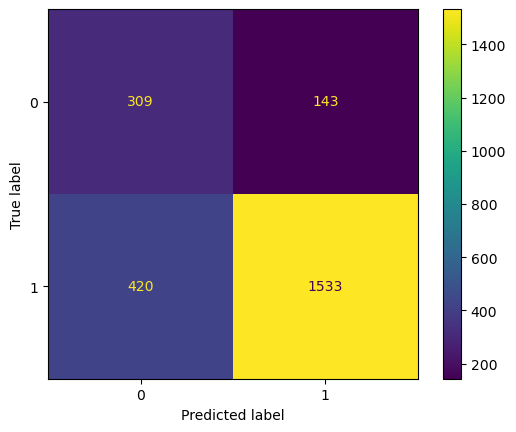

In [53]:
tree = DecisionTreeClassifier(max_depth=best_max_depth)

cross_validation(tree)

### Decision Tree Classifier performs worse than logistic regression and LDA.

## Model 6: Random Forest Classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
param_grid = {'n_estimators': [200, 500], 'max_depth' : [3, 5, 8]}

# find best parameters using grid search cv
rfc = RandomForestClassifier(random_state=25)
rfc_gscv = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=3, scoring="accuracy", n_jobs=4)
rfc_gscv.fit(X_train_re, y_train_re)

# get parameters
rf_max_depth = rfc_gscv.best_params_["max_depth"]
rf_n_estimators = rfc_gscv.best_params_["n_estimators"]

print(f"Random forest best max_depth: {rf_max_depth}; best n_estimators: {rf_n_estimators}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 4/5] END .....max_depth=3, n_estimators=200;, score=0.788 total time=  13.0s
[CV 2/5] END .....max_depth=3, n_estimators=200;, score=0.821 total time=  13.1s
[CV 3/5] END .....max_depth=3, n_estimators=200;, score=0.765 total time=  13.0s
[CV 1/5] END .....max_depth=3, n_estimators=200;, score=0.817 total time=  13.5s
[CV 5/5] END .....max_depth=3, n_estimators=200;, score=0.770 total time=  14.2s
[CV 2/5] END .....max_depth=3, n_estimators=500;, score=0.820 total time=  33.1s
[CV 3/5] END .....max_depth=3, n_estimators=500;, score=0.765 total time=  33.3s
[CV 1/5] END .....max_depth=3, n_estimators=500;, score=0.817 total time=  34.9s
[CV 4/5] END .....max_depth=3, n_estimators=500;, score=0.788 total time=  32.5s
[CV 1/5] END .....max_depth=5, n_estimators=200;, score=0.825 total time=  23.4s
[CV 2/5] END .....max_depth=5, n_estimators=200;, score=0.831 total time=  23.3s
[CV 5/5] END .....max_depth=3, n_estimators=500;,

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.808
Avg precision: 0.946
Avg recall: 0.819
Avg NPV: 0.505
Avg specificity: 0.797


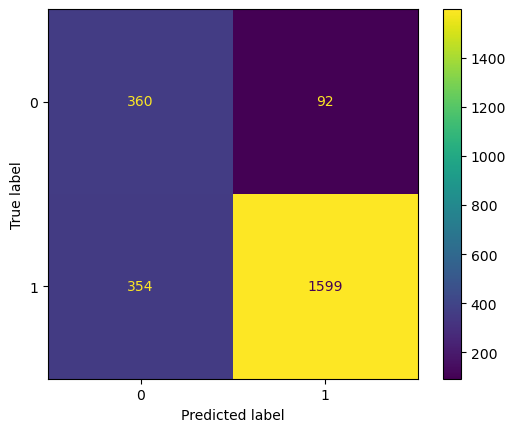

In [56]:
rf = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)

cross_validation(rf)

### Random Forest Classifier has the best performance so far.

## Model 7: AdaBoost (default parameters)

In [57]:
from sklearn.ensemble import AdaBoostClassifier

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.794
Avg precision: 0.943
Avg recall: 0.796
Avg NPV: 0.473
Avg specificity: 0.792


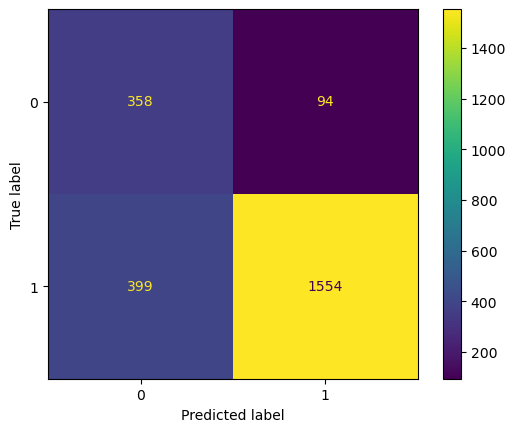

In [58]:
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME")

cross_validation(ada)

### AdaBoost (with default parameters) performs about as well as the random forest.

## Model 8: XGBoost (default parameters)

In [59]:
from xgboost import XGBClassifier

CV fold 1 complete
CV fold 2 complete
CV fold 3 complete
CV fold 4 complete
CV fold 5 complete

Classification metrics
Avg bal. accuracy: 0.774
Avg precision: 0.926
Avg recall: 0.842
Avg NPV: 0.509
Avg specificity: 0.706


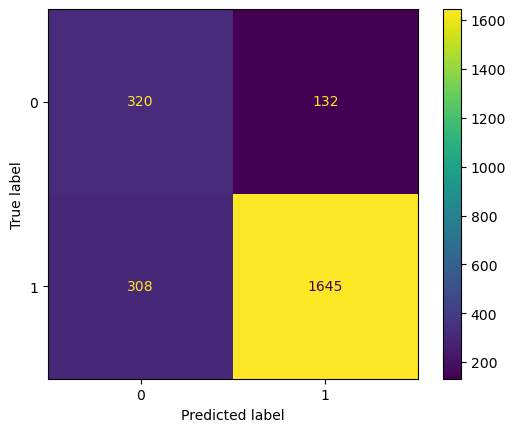

In [60]:
xgb = XGBClassifier()

cross_validation(xgb)

### XGBoost performs a bit worse than the random forest and AdaBoost models.